In [1201]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

# Extre libraries
from datetime import datetime

import joblib

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


In [1202]:
os.listdir('/kaggle/input/online-retail-ii-uci')

['online_retail_II.csv']

In [1203]:
data = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [1204]:
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


# Creating necessary columns

In [1205]:
# Making sure Date is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Total ammount column
data['TotalAmount'] = data['Price'] * data['Quantity']

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


# Dropping null columns

In [1206]:
# Validating null values
data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
TotalAmount         0
dtype: int64

In [1207]:
# Validating negative values
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price              5
Quantity       22950
TotalAmount    19498
dtype: int64

In [1208]:
# Deleting all rows with null values
data = data.dropna(subset = ['Customer ID'])

# Eliminating rows with negative quantities
data = data[data['Quantity'] >= 0]

data = data[data['Price'] >= 0]

In [1209]:
# Making lists with Customers with heavily outlying behavior
OutlierCustomersPrice = data[data['Price'] > data['Price'].quantile(0.9995)]['Customer ID'].unique()
OutlierCustomersQuantity = data[data['Quantity'] > data['Quantity'].quantile(0.9995)]['Customer ID'].unique()

# Combinning the lists
outlierCustomers = np.union1d(OutlierCustomersPrice, OutlierCustomersQuantity)

# Excluding outliers from data
data = data[~data['Customer ID'].isin(outlierCustomers)]

In [1210]:
# Validating null values again
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalAmount    0
dtype: int64

In [1211]:
# Validating negative values again
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price          0
Quantity       0
TotalAmount    0
dtype: int64

# Data Cleaning

<function matplotlib.pyplot.show(close=None, block=None)>

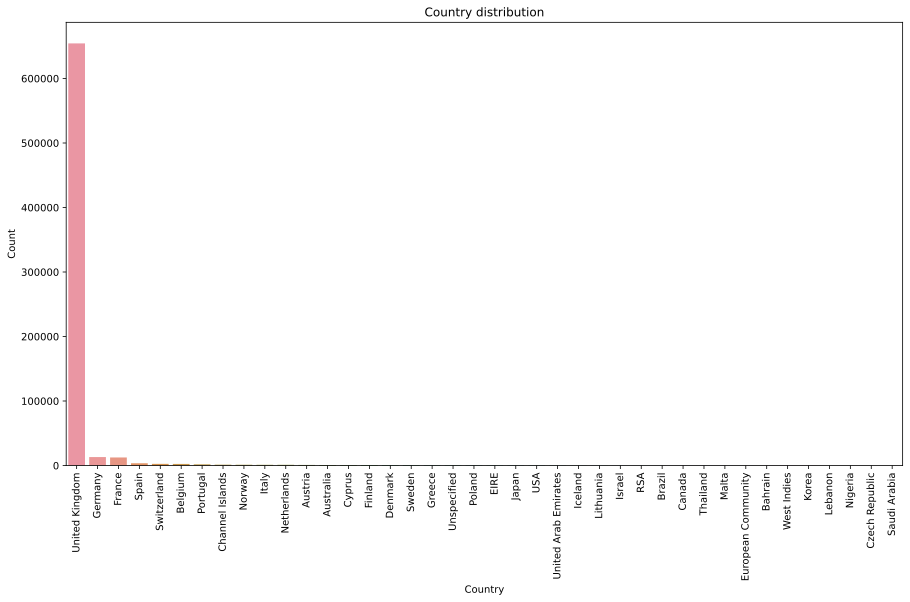

In [1212]:
# Country distribution
plt.figure(figsize=(15, 8))
sns.countplot(data= data, x='Country', order=data['Country'].value_counts().index)
plt.title('Country distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation= 90)
plt.show

In [1213]:
# We'll only work with transactions from the UK

# Keeping only transactions made in the UK
data = data[data['Country'] == 'United Kingdom']

In [1214]:
print(data['Country'].describe())

count             654357
unique                 1
top       United Kingdom
freq              654357
Name: Country, dtype: object


# Price, Quantity and Total Amount distributions

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Quantity', ylabel='Percent'>

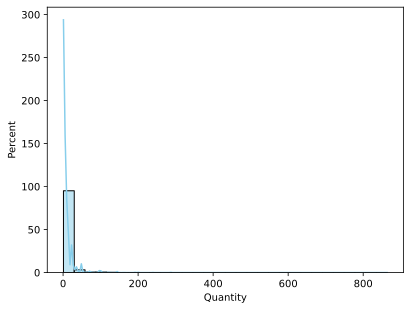

In [1215]:
sns.histplot(data['Quantity'],bins=30, kde=True, color="skyblue", stat="percent")

In [1216]:
# Distribution for Quantity
print(data['Quantity'].describe())

count    654357.000000
mean          9.653918
std          21.062353
min           1.000000
25%           2.000000
50%           4.000000
75%          12.000000
max         864.000000
Name: Quantity, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Percent'>

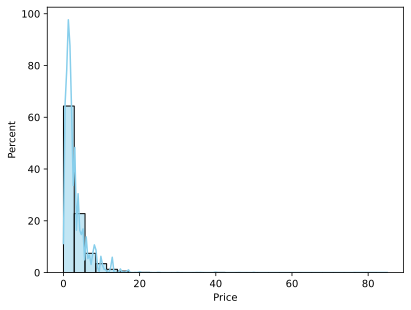

In [1217]:
sns.histplot(data['Price'],bins=30, kde=True, color="skyblue", stat="percent")

In [1218]:
# Distribution for Price
print(data['Price'].describe())

count    654357.000000
mean          2.874230
std           3.089849
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max          85.000000
Name: Price, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='TotalAmount', ylabel='Percent'>

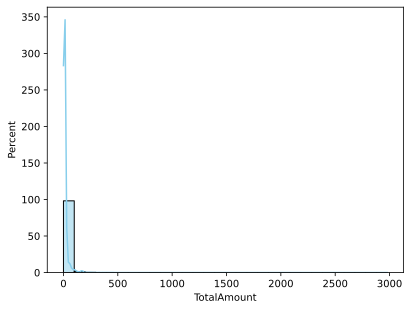

In [1219]:
sns.histplot(data['TotalAmount'],bins=30, kde=True, color="skyblue", stat="percent")

In [1220]:
# Distribution for TotalAmount
print(data['TotalAmount'].describe())

count    654357.000000
mean         16.637805
std          32.451979
min           0.000000
25%           4.160000
50%          10.200000
75%          17.700000
max        2978.400000
Name: TotalAmount, dtype: float64


# Data division between present and future

In [1221]:
futureMax = data['InvoiceDate'].max()

print(futureMax)

2011-12-09 12:49:00


In [1222]:
# Data delimitation (three months before)
presentvalue = pd.Timestamp('2011-09-01')

print(presentvalue)

2011-09-01 00:00:00


In [1223]:
# Dividing data between present and future
futureData = data[(data['InvoiceDate'] > presentvalue) & (data['InvoiceDate'] <= presentvalue + pd.DateOffset(months=3))]

data = data[data['InvoiceDate'] <= presentvalue]

In [1224]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [1225]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517704 entries, 0 to 846153
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      517704 non-null  object        
 1   StockCode    517704 non-null  object        
 2   Description  517704 non-null  object        
 3   Quantity     517704 non-null  int64         
 4   InvoiceDate  517704 non-null  datetime64[ns]
 5   Price        517704 non-null  float64       
 6   Customer ID  517704 non-null  float64       
 7   Country      517704 non-null  object        
 8   TotalAmount  517704 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 39.5+ MB


In [1226]:
futureData.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
846166,565080,20677,PINK POLKADOT BOWL,8,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,10.0
846167,565080,22128,PARTY CONES CANDY ASSORTED,24,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,30.0
846169,565082,22423,REGENCY CAKESTAND 3 TIER,2,2011-09-01 09:15:00,12.75,13305.0,United Kingdom,25.5
846170,565082,15060B,FAIRY CAKE DESIGN UMBRELLA,8,2011-09-01 09:15:00,3.75,13305.0,United Kingdom,30.0
846171,565082,23245,SET OF 3 REGENCY CAKE TINS,4,2011-09-01 09:15:00,4.95,13305.0,United Kingdom,19.8


In [1227]:
futureData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122624 entries, 846166 to 1041829
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      122624 non-null  object        
 1   StockCode    122624 non-null  object        
 2   Description  122624 non-null  object        
 3   Quantity     122624 non-null  int64         
 4   InvoiceDate  122624 non-null  datetime64[ns]
 5   Price        122624 non-null  float64       
 6   Customer ID  122624 non-null  float64       
 7   Country      122624 non-null  object        
 8   TotalAmount  122624 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 9.4+ MB


# Creating Customer Dataset

In [1228]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [1229]:
# Calculating the "present day" for metrics like Recency
presentDay = presentvalue

# Calculate date metrics
firstPurchase = data.groupby('Customer ID')['InvoiceDate'].min()
lastPurchase = data.groupby('Customer ID')['InvoiceDate'].max()

# Calculate customer lifespan metrics
# We don't want 0 in active days. First day counts as 1.
activeDays = (lastPurchase - firstPurchase).dt.days + 1

# Recency calculation (Days since last purchase)
recency = (presentDay - lastPurchase).dt.days

activeYears = activeDays / 365.25
activeMonths = activeDays / 30.44

# A stabilization for active months so FrequencyPerMonth doesn't give
# new customer extreme values
activeMonthsSafe = np.maximum(activeMonths, 1)

# Last 90 days
last_90d = data[data['InvoiceDate'] > presentDay - pd.DateOffset(days=90)]
last_90d_spending = last_90d.groupby('Customer ID')['TotalAmount'].sum()
last_90d_frequency = last_90d.groupby('Customer ID')['Invoice'].nunique()

# Frequency calculation
purchaseFrequency = data.groupby('Customer ID')['Invoice'].nunique()

# Monetary for calculations
monetary = data.groupby('Customer ID')['TotalAmount'].sum()

# Quantity calculation (calculating the total quantity per invoice)
invoiceQuantity = data.groupby(['Customer ID','Invoice'])['Quantity'].sum().reset_index()
avgQuantityPerInvoice = invoiceQuantity.groupby('Customer ID')['Quantity'].mean()

customerData = data.groupby('Customer ID').agg(

    # Monetary (Total Amount of purchases)
    Monetary = ('TotalAmount', 'sum'),
    
    # Average item Price
    #AvgPrice = ('Price', 'mean'), 
    
    # How many unique products bought
    ProductDiversity = ('StockCode', 'nunique')
)

# Recency calculation (Days since last purchase)
customerData['Recency'] = recency

# Frequency calculation
customerData['Frequency'] = purchaseFrequency

# Average order value calculation
customerData['AvgInvoiceValue'] = monetary / purchaseFrequency

# Average Quantity table merge
customerData['AvgQuantityPerInvoice'] = avgQuantityPerInvoice

# Active days
customerData['ActiveDays'] = activeDays

# Average item price
AvgPrice = data.groupby('Customer ID').apply(lambda x: x['TotalAmount'].sum() / x['Quantity'].sum())

# Spending in different time windows
customerData['Spending_Last90d'] = last_90d_spending

# Frequency in different time windows
customerData['Frequency_Last90d'] = last_90d_frequency

# Fill NaN values with 0 for customers with no activity in recent windows
temporal_cols = ['Spending_Last90d', 'Frequency_Last90d']

customerData[temporal_cols] = customerData[temporal_cols].fillna(0)

# Frequency per month
customerData['FrequencyPerMonth'] = purchaseFrequency / activeMonthsSafe

# Calculation of future CLV (spending in the next Quarter), which will be the target
futureCLV = futureData.groupby('Customer ID')['TotalAmount'].sum().rename('FutureCLV')
finalDataset = customerData.merge(futureCLV, how = 'left', left_index = True, right_index = True)
# Filling customers with no spending with a 0 value
finalDataset['FutureCLV'] = finalDataset['FutureCLV'].fillna(0)

finalDataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4574 entries, 12608.0 to 18287.0
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Monetary               4574 non-null   float64
 1   ProductDiversity       4574 non-null   int64  
 2   Recency                4574 non-null   int64  
 3   Frequency              4574 non-null   int64  
 4   AvgInvoiceValue        4574 non-null   float64
 5   AvgQuantityPerInvoice  4574 non-null   float64
 6   ActiveDays             4574 non-null   int64  
 7   Spending_Last90d       4574 non-null   float64
 8   Frequency_Last90d      4574 non-null   float64
 9   FrequencyPerMonth      4574 non-null   float64
 10  FutureCLV              4574 non-null   float64
dtypes: float64(7), int64(4)
memory usage: 428.8 KB


/tmp/ipykernel_47/4164582609.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  AvgPrice = data.groupby('Customer ID').apply(lambda x: x['TotalAmount'].sum() / x['Quantity'].sum())


In [1230]:
finalDataset.head(10)

,Monetary,ProductDiversity,Recency,Frequency,AvgInvoiceValue,AvgQuantityPerInvoice,ActiveDays,Spending_Last90d,Frequency_Last90d,FrequencyPerMonth,FutureCLV
Customer ID,,,,,,,,,,,
12608.0,415.79,16,304,1,415.790000,323.000000,1,0.00,0.0,1.000000,0.00
12746.0,254.55,17,440,1,254.550000,97.000000,1,0.00,0.0,1.000000,0.00
12747.0,7849.93,79,9,23,341.301304,101.956522,623,678.00,2.0,1.123788,988.11
12749.0,5561.71,219,30,7,794.530000,281.285714,391,1896.13,2.0,0.544962,572.59
12777.0,519.45,26,357,1,519.450000,458.000000,1,0.00,0.0,1.000000,0.00
12819.0,540.52,19,358,1,540.520000,344.000000,1,0.00,0.0,1.000000,0.00
12820.0,1917.64,91,226,8,239.705000,173.750000,408,0.00,0.0,0.596863,561.53
12821.0,220.80,13,114,2,110.400000,81.000000,398,0.00,0.0,0.152965,0.00
12823.0,5966.00,1,27,17,350.941176,50.588235,553,229.50,1.0,0.935769,535.50


In [1231]:
# Saving a clean copy of the final dataset before cleaning it
rawCustomerDataset = finalDataset.copy()

# Client segmentation (Excluding clients with outlying purchase patters)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Monetary', ylabel='Percent'>

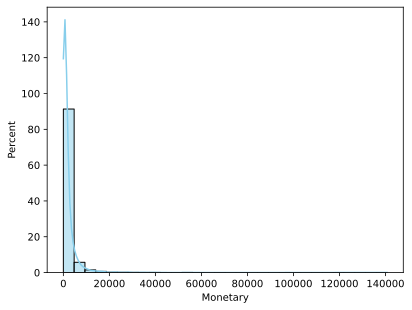

In [1232]:
sns.histplot(finalDataset['Monetary'],bins=30, kde=True, color="skyblue", stat="percent")

In [1233]:
print(finalDataset['Monetary'].describe())

count      4574.000000
mean       1907.339452
std        4862.633444
min           0.000000
25%         307.355000
50%         723.990000
75%        1857.310000
max      140716.640000
Name: Monetary, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgInvoiceValue', ylabel='Percent'>

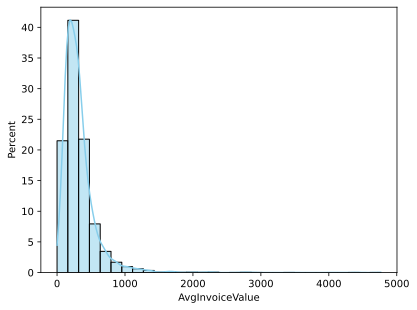

In [1234]:
sns.histplot(finalDataset['AvgInvoiceValue'],bins=30, kde=True, color="skyblue", stat="percent")

In [1235]:
print(finalDataset['AvgInvoiceValue'].describe())

count    4574.000000
mean      321.689670
std       260.997402
min         0.000000
25%       170.462500
50%       268.315833
75%       388.537500
max      4765.040000
Name: AvgInvoiceValue, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgQuantityPerInvoice', ylabel='Percent'>

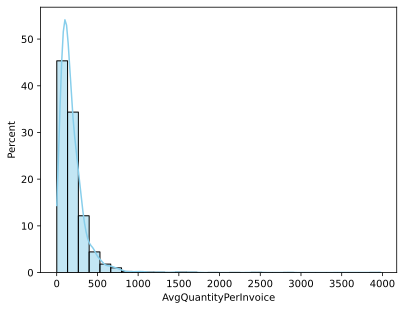

In [1236]:
sns.histplot(finalDataset['AvgQuantityPerInvoice'],bins=30, kde=True, color="skyblue", stat="percent")

In [1237]:
print(finalDataset['AvgQuantityPerInvoice'].describe())

count    4574.000000
mean      189.125637
std       182.028409
min         1.000000
25%        86.270833
50%       144.171429
75%       238.598039
max      3976.875000
Name: AvgQuantityPerInvoice, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FrequencyPerMonth', ylabel='Percent'>

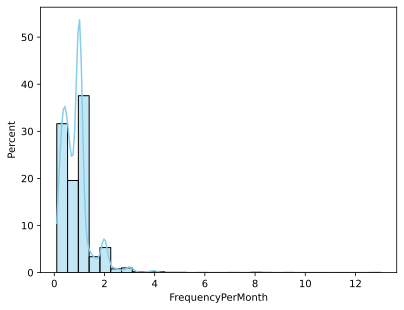

In [1238]:
sns.histplot(finalDataset['FrequencyPerMonth'],bins=30, kde=True, color="skyblue", stat="percent")

In [1239]:
print(finalDataset['FrequencyPerMonth'].describe())

count    4574.000000
mean        0.882221
std         0.649248
min         0.099477
25%         0.454328
50%         0.908657
75%         1.000000
max        12.997796
Name: FrequencyPerMonth, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Frequency', ylabel='Percent'>

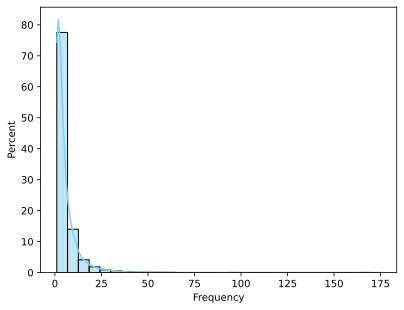

In [1240]:
sns.histplot(finalDataset['Frequency'],bins=30, kde=True, color="skyblue", stat="percent")

In [1241]:
print(finalDataset['Frequency'].describe())

count    4574.00000
mean        5.20857
std         8.71924
min         1.00000
25%         1.00000
50%         3.00000
75%         6.00000
max       175.00000
Name: Frequency, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FutureCLV', ylabel='Percent'>

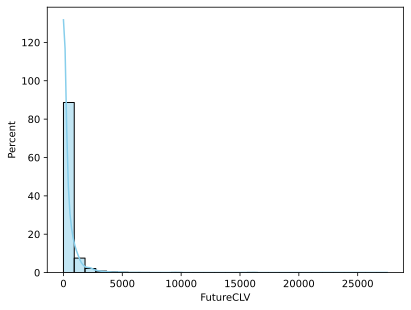

In [1242]:
sns.histplot(finalDataset['FutureCLV'],bins=30, kde=True, color="skyblue", stat="percent")

In [1243]:
print(finalDataset['FutureCLV'].describe())

count     4574.000000
mean       355.097285
std       1003.274425
min          0.000000
25%          0.000000
50%          0.000000
75%        381.810000
max      27507.590000
Name: FutureCLV, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Monetary', ylabel='Percent'>

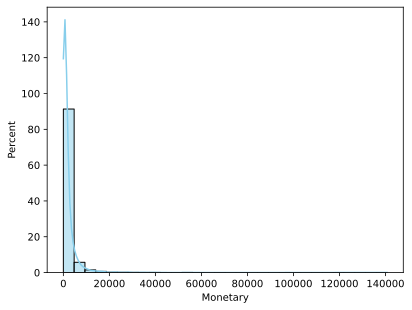

In [1244]:
sns.histplot(finalDataset['Monetary'],bins=30, kde=True, color="skyblue", stat="percent")

In [1245]:
print(finalDataset['Monetary'].describe())

count      4574.000000
mean       1907.339452
std        4862.633444
min           0.000000
25%         307.355000
50%         723.990000
75%        1857.310000
max      140716.640000
Name: Monetary, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgInvoiceValue', ylabel='Percent'>

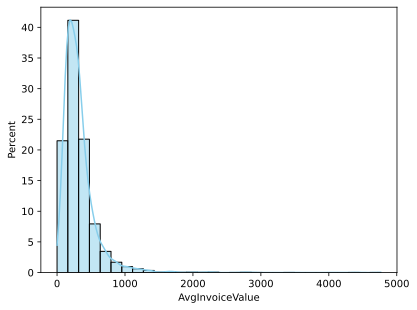

In [1246]:
sns.histplot(finalDataset['AvgInvoiceValue'],bins=30, kde=True, color="skyblue", stat="percent")

In [1247]:
print(finalDataset['AvgInvoiceValue'].describe())

count    4574.000000
mean      321.689670
std       260.997402
min         0.000000
25%       170.462500
50%       268.315833
75%       388.537500
max      4765.040000
Name: AvgInvoiceValue, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgQuantityPerInvoice', ylabel='Percent'>

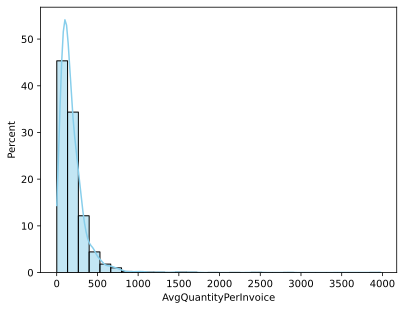

In [1248]:
sns.histplot(finalDataset['AvgQuantityPerInvoice'],bins=30, kde=True, color="skyblue", stat="percent")

In [1249]:
print(finalDataset['AvgQuantityPerInvoice'].describe())

count    4574.000000
mean      189.125637
std       182.028409
min         1.000000
25%        86.270833
50%       144.171429
75%       238.598039
max      3976.875000
Name: AvgQuantityPerInvoice, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FrequencyPerMonth', ylabel='Percent'>

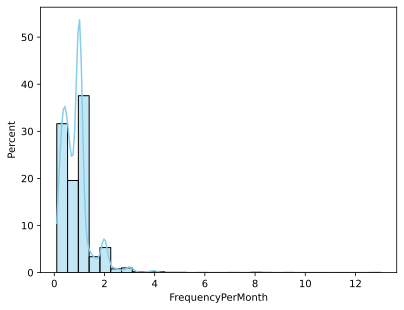

In [1250]:
sns.histplot(finalDataset['FrequencyPerMonth'],bins=30, kde=True, color="skyblue", stat="percent")

In [1251]:
print(finalDataset['FrequencyPerMonth'].describe())

count    4574.000000
mean        0.882221
std         0.649248
min         0.099477
25%         0.454328
50%         0.908657
75%         1.000000
max        12.997796
Name: FrequencyPerMonth, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Frequency', ylabel='Percent'>

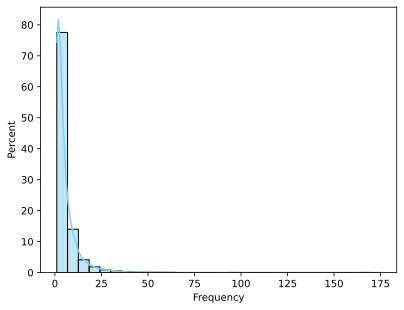

In [1252]:
sns.histplot(finalDataset['Frequency'],bins=30, kde=True, color="skyblue", stat="percent")

In [1253]:
print(finalDataset['Frequency'].describe())

count    4574.00000
mean        5.20857
std         8.71924
min         1.00000
25%         1.00000
50%         3.00000
75%         6.00000
max       175.00000
Name: Frequency, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FutureCLV', ylabel='Percent'>

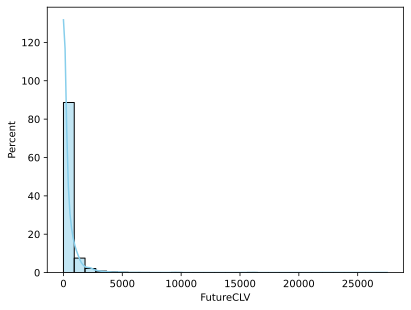

In [1254]:
sns.histplot(finalDataset['FutureCLV'],bins=30, kde=True, color="skyblue", stat="percent")

In [1255]:
print(finalDataset['FutureCLV'].describe())

count     4574.000000
mean       355.097285
std       1003.274425
min          0.000000
25%          0.000000
50%          0.000000
75%        381.810000
max      27507.590000
Name: FutureCLV, dtype: float64


# Data normalization, split and coversion into tensors

In [1256]:
modelData = finalDataset.copy()

In [1257]:
# Separating features from target
X = modelData.drop(columns=['FutureCLV'])
y = modelData['FutureCLV']

# 75 / 15 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

print(X_train.shape, X_val.shape)

(3887, 10) (687, 10)


In [1258]:
# log1p
X_train_log = np.log1p(X_train)
X_val_log   = np.log1p(X_val)

In [1259]:
# Robust Scaler

# Initialize scaler
scaler = RobustScaler()

# Fit only for train data
scaler.fit(X_train_log)

# Saving the scaler for later use (In the app)
joblib.dump(scaler, "robust_scaler.pkl")

['robust_scaler.pkl']

In [1260]:
X_train_scaled = scaler.transform(X_train_log)
X_val_scaled = scaler.transform(X_val_log)

In [1261]:
# Pandas dataframe to tensor conversion
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

In [1262]:
batchSize = 32

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)

train_loader = DataLoader(train_ds, batch_size=batchSize, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batchSize, shuffle=False)

In [1263]:
print(X_train_t.shape)
print(X_val_t.shape)

torch.Size([3887, 10])
torch.Size([687, 10])


# Creating and trainning the FFNN

In [1264]:
# Creating a class for the model without batchnorm

class FFNN(nn.Module):
  def __init__(self):
    super().__init__()

    # input layer
    self.input = nn.Linear(10,128)

    # hidden layer 1
    self.fc1    = nn.Linear(128,64)

    # hidden layer 2
    self.fc2    = nn.Linear(64,32)

    # output layer
    self.output = nn.Linear(32,1)

    # Dropout
    self.dropout = nn.Dropout(p=0.3)

  # forward pass
  def forward(self,x):

    # input
    x = self.input(x)    # weighted combination
    x = F.relu(x)      # activation function 
      
    # hidden layer 1
    x = self.fc1(x)    # weighted combination
    x = F.relu(x)      # activation function
    x = self.dropout(x)  # dropout
    
    # hidden layer 2
    x = self.fc2(x)    # weighted combination
    x = F.relu(x)      # activation function 

    # output layer
    return self.output(x)

In [1265]:
# grab an instance of the model class
model = FFNN()

# loss function
lossfun = nn.MSELoss() 

# optimizer
optimizer = torch.optim.AdamW(model.parameters(),lr= 0.001,weight_decay=0.0001)

# Scheduler for learning rate decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,     # reduce LR by half
    patience=15,     # wait 15 epochs with no improvement
    min_lr = 0.000001
)

In [1266]:
# train the model

# Evaluation function
def evaluateModel(model, loader):
    model.eval()

    preds = []
    trues = []

    with torch.no_grad():
            for X, y in loader:
                yhat = model(X)
                preds.append(yhat.cpu().numpy())
                trues.append(y.cpu().numpy())

    preds = np.vstack(preds).ravel()
    trues = np.vstack(trues).ravel()

    mae = mean_absolute_error(trues, preds) 
    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2 = r2_score(trues, preds)

    return mae, rmse, r2

# Epochs
numepochs = 200

def trainTheModel():

    # initialize losses as empties
    trainLosses = []
    valLosses = []
    
    valMAEs = []
    valRMSEs = []
    valR2s = []
    
    # loop over epochs
    for epoch in range(numepochs):
    
        # Toggle train mode
        model.train()
        batchLoss = []
          
        # initialize batchAcc and batchLoss
        batchAcc  = []
        batchLoss = []
        
        for X,y in train_loader:
          # Clear old gradients  
          optimizer.zero_grad()  
        
          # forward pass and loss
          yhat = model(X)
          loss = lossfun(yhat,y)
        
          # backprop
          loss.backward()
          optimizer.step()
        
          # Append batch Loss
          batchLoss.append( loss.item())
          
        # Average trainning loss for this epoch
        trainLoss = np.mean(batchLoss)
        trainLosses.append(trainLoss)

        # Turning on validation mode
        model.eval()
        with torch.no_grad():
            valLossBatch = []

            for Xv, yv in val_loader:
                yhatv = model(Xv)
                valLossBatch.append(lossfun(yhatv, yv).item())

        valLoss = np.mean(valLossBatch)
        valLosses.append(valLoss)

        # Metrics
        mae, rmse, r2 = evaluateModel(model, val_loader)

        valMAEs.append(mae)
        valRMSEs.append(rmse)
        valR2s.append(r2)
            
        # Scheduler
        scheduler.step(valLoss)

        # Progress print
        if epoch % 5 == 0:
            print(
                f"Epoch {epoch:03d} | "
                f"TrainLoss: {trainLoss:.4f} | "
                f"ValLoss: {valLoss:.4f} | "
                f"MAE: £{mae:.2f} | "
                f"RMSE: £{rmse:.2f} | "
                f"R²: {r2:.3f} | "
                f"LR: {optimizer.param_groups[0]['lr']:.6f}"
            )
    
    # function output
    return trainLosses, valLosses, valMAEs, valRMSEs, valR2s

In [1267]:
# Train the model
trainLosses, valLosses, valMAEs, valRMSEs, valR2s = trainTheModel()

Epoch 000 | TrainLoss: 1135202.2410 | ValLoss: 708840.6793 | MAE: £325.86 | RMSE: £850.10 | R²: 0.095 | LR: 0.001000
Epoch 005 | TrainLoss: 682903.0447 | ValLoss: 451037.0866 | MAE: £327.09 | RMSE: £675.53 | R²: 0.428 | LR: 0.001000
Epoch 010 | TrainLoss: 642892.1312 | ValLoss: 420035.0973 | MAE: £310.67 | RMSE: £651.15 | R²: 0.469 | LR: 0.001000
Epoch 015 | TrainLoss: 617897.9326 | ValLoss: 398511.8835 | MAE: £303.66 | RMSE: £633.88 | R²: 0.497 | LR: 0.001000
Epoch 020 | TrainLoss: 581768.3218 | ValLoss: 385901.1779 | MAE: £297.60 | RMSE: £624.03 | R²: 0.512 | LR: 0.001000
Epoch 025 | TrainLoss: 574768.8312 | ValLoss: 373641.4996 | MAE: £295.46 | RMSE: £613.42 | R²: 0.529 | LR: 0.001000
Epoch 030 | TrainLoss: 553473.3749 | ValLoss: 368649.8072 | MAE: £295.18 | RMSE: £609.66 | R²: 0.534 | LR: 0.001000
Epoch 035 | TrainLoss: 512904.9666 | ValLoss: 387228.7276 | MAE: £312.58 | RMSE: £623.24 | R²: 0.513 | LR: 0.001000
Epoch 040 | TrainLoss: 491090.2100 | ValLoss: 362442.2729 | MAE: £295.4

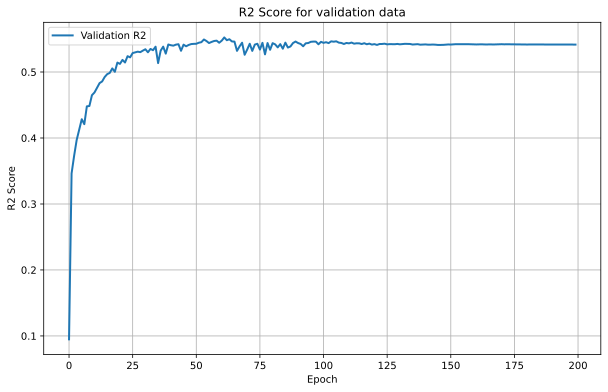

In [1268]:
plt.figure(figsize=(10,6))

plt.plot(valR2s, label='Validation R2', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('R2 Score for validation data')
plt.legend()
plt.grid(True)
plt.show()

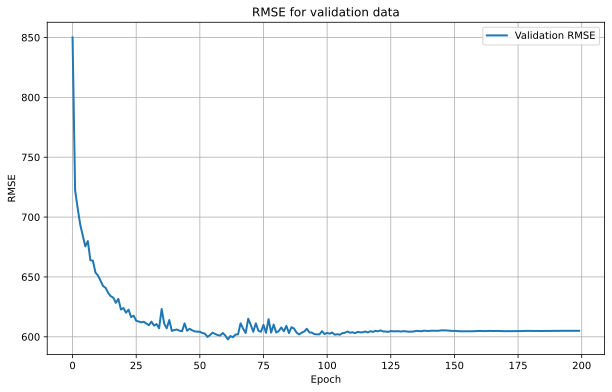

In [1269]:
plt.figure(figsize=(10,6))

plt.plot(valRMSEs, label='Validation RMSE', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE for validation data')
plt.legend()
plt.grid(True)
plt.show()

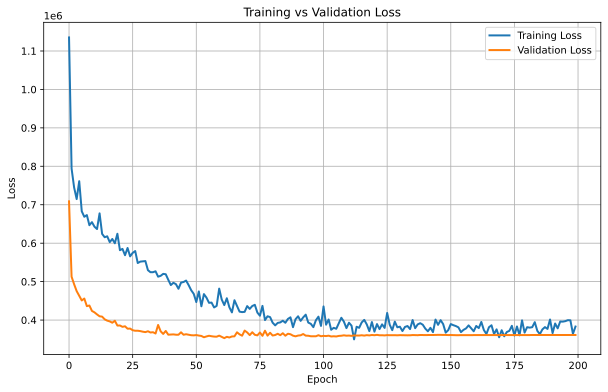

In [1270]:
plt.figure(figsize=(10,6))

plt.plot(trainLosses, label='Training Loss', linewidth=2)
plt.plot(valLosses, label='Validation Loss', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [1271]:
# Saving the model as .pt file
torch.save(model.state_dict(), 'FFNN_model.pt')